In [1]:
import torch
import os
import sys
import os
import numpy as np
from torch import nn
import torchmetrics
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose 
from scipy.special import softmax
from tqdm import tqdm
sys.path.insert(0,'../../bnn_bbb/utils')
from models import Resnet_regime_3
from model_resnet import Resnet20_classic

In [2]:
model_1 = Resnet_regime_3.load_from_checkpoint("../../explotation/resnet/bnn_1.ckpt")
model_01 = Resnet_regime_3.load_from_checkpoint("../../explotation/resnet/bnn_01.ckpt")
model_001 = Resnet_regime_3.load_from_checkpoint("../../explotation/resnet/bnn_001.ckpt")
#model_10 = Resnet_regime_3.load_from_checkpoint("../../explotation/resnet/bnn_10.ckpt")
model_100 = Resnet_regime_3.load_from_checkpoint("../../explotation/resnet/bnn_100.ckpt")
model_500 = Resnet_regime_3.load_from_checkpoint("../../explotation/resnet/bnn_500.ckpt")
#model_1000 = Resnet_regime_3.load_from_checkpoint("../../explotation/output/linear_bnn_1000.ckpt")
# model_0001 = Resnet_regime_3.load_from_checkpoint("../../explotation/output/linear_bnn_0001.ckpt")

In [3]:
batch_size = 600
num_works= 0
test_transform = Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
val_dataset = CIFAR10('../', download=True, transform=test_transform, train=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_works)

Files already downloaded and verified


In [4]:
nb_samples = 1

ECE = torchmetrics.CalibrationError(n_bins=15, norm='l1')  
accuracy = torchmetrics.Accuracy()  
criterion = nn.CrossEntropyLoss(reduction='mean')

def compute(model, dataset):
    acc, ece, nll, conf = 0, 0, 0, 0
    for x, y in dataset:
        pred = torch.empty(nb_samples, x.size()[0], 10)
        for idx in range(nb_samples):
            pred[idx, :] = model(x).softmax(dim=1)
            
        avg_pred = pred.mean(dim=0)
        pred_prob = avg_pred[range(avg_pred.size()[0]), y]
        nll += - torch.log(pred_prob).mean()
        
        accuracy.update(avg_pred, y)
        acc += accuracy.compute().item()
        
        ECE.update(avg_pred, y)
        ece += ECE.compute().item()
        
        conf += pred_prob.mean()
        
        ECE.reset()
        accuracy.reset()
    return acc/len(dataset), ece / len(dataset), nll / len(dataset), conf / len(dataset)
    

In [5]:
models = [(0.01, model_001),
         (0.1, model_01),
         (1., model_1),
         (100, model_100),
         (500, model_500)]

In [ ]:
eta_list, acc_list, ece_list, nll_list, p_list = [], [], [], [], []
eta_list_nn, acc_list_nn, ece_list_nn, nll_list_nn, p_list_nn = [], [], [], [], []
for eta, model in tqdm(models):
    print(eta, model.model_params['w'])
    acc, ece, nll, p = compute(model, val_loader)
#     acc_nn, ece_nn, nll_nn, p_nn = compute(nn, val_loader)
    eta_list.append(eta)
    ece_list.append(ece)
    acc_list.append(acc)
    nll_list.append(nll)
    p_list.append(p)
    del model

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.01 541812


In [ ]:
plt.plot(eta_list, acc_list, '-o', label='BNN')
plt.plot(eta_list, acc_list_nn, '-o', label='NN')
plt.xscale('log')
plt.legend()
plt.show()
print(eta_list[np.argmax(acc_list)])

In [ ]:
plt.plot(eta_list, ece_list, '-o', label='BNN')
plt.plot(eta_list, ece_list_nn, '-o', label='NN')
plt.xscale('log')
plt.legend()
plt.show()
print(eta_list[np.argmin(ece_list)])

In [ ]:
plt.plot(eta_list, p_list, '-o', label='BNN')
plt.plot(eta_list, p_list_nn, '-o', label='NN')
plt.xscale('log')
plt.legend()
plt.show()
print(eta_list[np.argmin(p_list)])

In [ ]:
plt.plot(eta_list, nll_list, '-o', label='BNN')
plt.plot(eta_list, nll_list_nn, '-o', label='NN')
plt.xscale('log')
plt.legend()
plt.show()
print(eta_list[np.argmin(nll_list)])

In [2]:
import pickle as pkl
results = pkl.load(open('results.pkl', 'rb'))


In [5]:
import matplotlib.pyplot as plt
eta = results['eta_list']

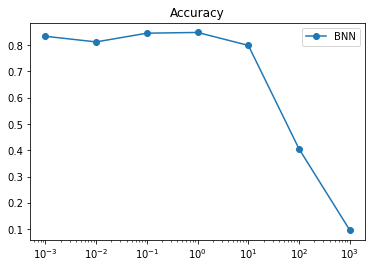

In [8]:
plt.plot(eta, results['acc_list'], '-o', label='BNN')
plt.xscale('log')
plt.legend()
plt.title('Accuracy')
plt.show()